In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/magisterka

/content/drive/My Drive/magisterka


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from enum import Enum, auto
import json

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from scripts.data_processing.market_data_processing import prepare_market_data_for_model, \
add_sentiment_features_from_articles, add_sentiments_from_reddit
from model_training.price_model_training import train_price_prediction_model, ModelType, LossFunction
from model_training.price_model_validation import *
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
np.random.seed(120)
random.seed(120)

In [5]:
base_path = '/content/drive/My Drive/magisterka/data/market_data'

In [6]:
X, y = prepare_market_data_for_model("btc_merged.csv", base_path, horizon=12*12)

In [7]:
texts = pd.read_csv("/content/drive/My Drive/magisterka/data/results/articles_labeled.csv")
comments = pd.read_csv("/content/drive/My Drive/magisterka/data/results/comments_labeled_non_finetuned.csv")

In [8]:
X = add_sentiment_features_from_articles(X, texts, windows_hours=(2, 6, 12, 24))

In [9]:
X = add_sentiments_from_reddit(X, comments, windows_hours=(2, 6, 12, 24))

In [10]:
X

price_over_ema4h  price_over_ema2h  volatility_4h  \
timestamp                                                                      
2025-04-12 00:15:00+00:00         -0.000955         -0.000257       0.000922   
2025-04-12 00:20:00+00:00         -0.001689         -0.000979       0.000927   
2025-04-12 00:25:00+00:00         -0.002482         -0.001727       0.000914   
2025-04-12 00:30:00+00:00         -0.002018         -0.001241       0.000910   
2025-04-12 00:35:00+00:00         -0.000833         -0.000084       0.000920   
...                                     ...               ...            ...   
2025-06-06 11:35:00+00:00          0.002404          0.000878       0.000510   
2025-06-06 11:40:00+00:00          0.001807          0.000330       0.000473   
2025-06-06 11:45:00+00:00          0.002057          0.000613       0.000474   
2025-06-06 11:50:00+00:00          0.002950          0.001500       0.000491   
2025-06-06 11:55:00+00:00          0.003464          0.001988       0.000496   

                           volatility_wh  volume_z       s_t  log_return_t-1  \
timestamp                                                                      
2025-04-12 00:15:00+00:00       0.001576 -0.722191  0.001576       -0.000807   
2025-04-12 00:20:00+00:00       0.001575 -0.798340  0.001575       -0.000900   
2025-04-12 00:25:00+00:00       0.001575 -0.606952  0.001575        0.000379   
2025-04-12 00:30:00+00:00       0.001575 -0.739591  0.001575        0.001151   
2025-04-12 00:35:00+00:00       0.001574 -0.728959  0.001574        0.000652   
...                                  ...       ...       ...             ...   
2025-06-06 11:35:00+00:00       0.001178 -0.146593  0.001178       -0.000519   
2025-06-06 11:40:00+00:00       0.001178 -0.507527  0.001178        0.000337   
2025-06-06 11:45:00+00:00       0.001179 -0.326600  0.001179        0.001017   
2025-06-06 11:50:00+00:00       0.001180 -0.616530  0.001180        0.000660   
2025-06-06 11:55:00+00:00       0.001181 -0.327296  0.001181       -0.000215   

                           news_any  sentiment_mean_2h  news_count_2h  ...  \
timestamp                                                              ...   
2025-04-12 00:15:00+00:00       0.0                0.0            0.0  ...   
2025-04-12 00:20:00+00:00       0.0                0.0            0.0  ...   
2025-04-12 00:25:00+00:00       0.0                0.0            0.0  ...   
2025-04-12 00:30:00+00:00       0.0                0.0            0.0  ...   
2025-04-12 00:35:00+00:00       0.0                0.0            0.0  ...   
...                             ...                ...            ...  ...   
2025-06-06 11:35:00+00:00       0.0                0.0            0.0  ...   
2025-06-06 11:40:00+00:00       0.0                0.0            0.0  ...   
2025-06-06 11:45:00+00:00       0.0                0.0            0.0  ...   
2025-06-06 11:50:00+00:00       0.0                0.0            0.0  ...   
2025-06-06 11:55:00+00:00       0.0                0.0            0.0  ...   

                           has_comment  comment_count  reddit_sentiment_2h  \
timestamp                                                                    
2025-04-12 00:15:00+00:00          1.0       0.693147                  0.0   
2025-04-12 00:20:00+00:00          0.0       0.000000                  0.0   
2025-04-12 00:25:00+00:00          0.0       0.000000                  0.0   
2025-04-12 00:30:00+00:00          0.0       0.000000                  0.0   
2025-04-12 00:35:00+00:00          0.0       0.000000                  0.0   
...                                ...            ...                  ...   
2025-06-06 11:35:00+00:00          0.0       0.000000                  0.0   
2025-06-06 11:40:00+00:00          0.0       0.000000                  0.0   
2025-06-06 11:45:00+00:00          0.0       0.000000                  0.0   
2025-06-06 11:50:00+00:00          0.0       0.000000                  0

In [11]:
split = TimeSeriesSplit(n_splits=5)

# LSTM - trenowanie

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.7301 - val_loss: 0.9007 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5516 - val_loss: 0.8899 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4560 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4294 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3879 - val_loss: 0.9684 - learning_rate: 5.0000e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3850 - val_loss: 0.9900 - learning_rate: 5.0000e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3690 - val_loss: 0.9897 - learning_rate: 2.5000e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3682 - val_loss: 0.9974 - learning_rate: 2.5000e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3436 - val_loss: 1.0003 - learning_rate: 1

/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


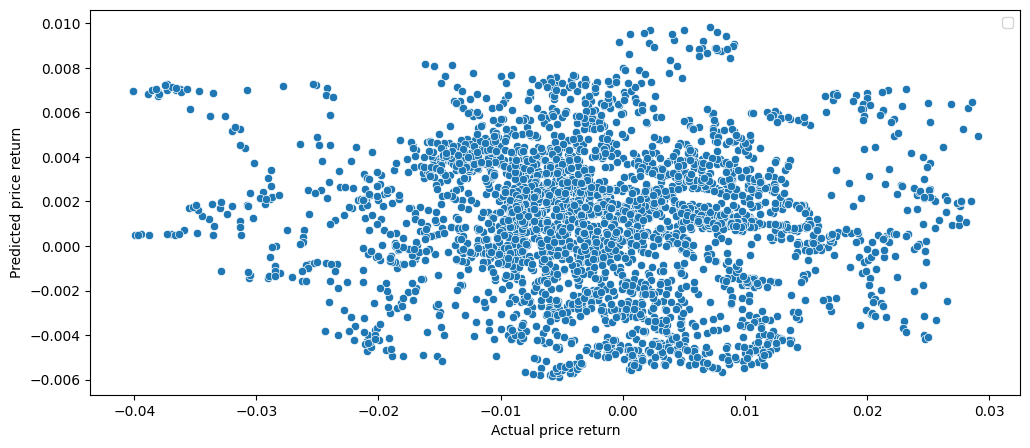

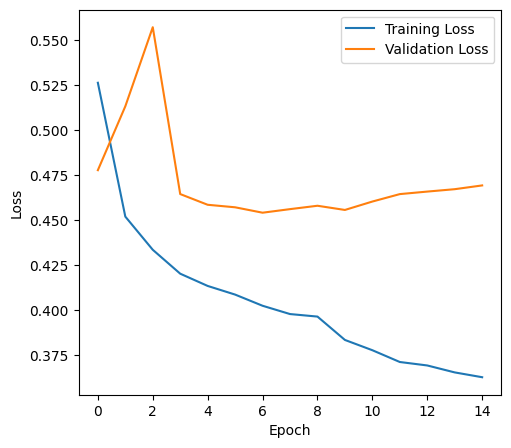

=== Cross-validation (validation folds) ===
mean CV MSE: 0.00018245035607833415
mean CV MAE: 0.010108090937137604
mean CV DA: 0.5063376874697629
mean CV SR: 0.039304862454620074
mean CV R^2: -0.2540567636489868
mean CV Pearson correlation: -0.16158491373062134


/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


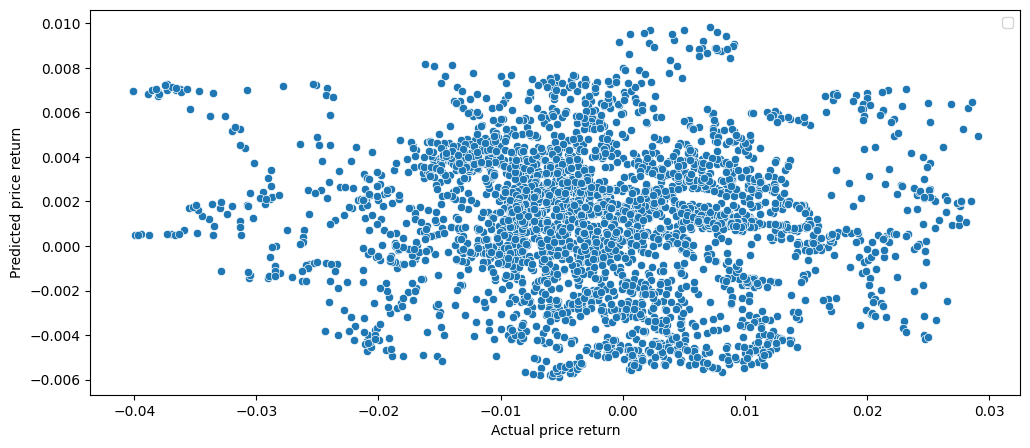

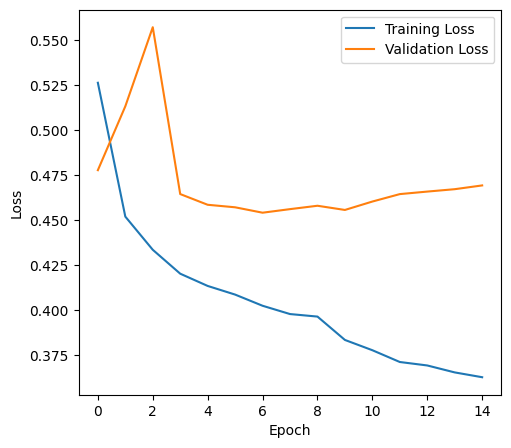

successfully saved training's output to lstm_btc_scores_final_comments_1.json


In [ ]:
lstm_1_scores, lstm_1_history = train_price_prediction_model(X, y, ModelType.LSTM, split, "lstm_btc_scores_final_comments_1.json", dropout=0.2, num_neurons=32, batch_size=128, seq_length=64, learning_rate=0.001, epochs=100, loss_funtion=LossFunction.HUBER)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.7671 - val_loss: 0.8355 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5508 - val_loss: 0.8424 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5516 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5439 - val_loss: 0.8720 - learning_rate: 5.0000e-04
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4879 - val_loss: 0.8845 - learning_rate: 5.0000e-04
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4813 - val_loss: 0.8974 - learning_rate: 2.5000e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4776 - val_loss: 0.9013 - learning_rate: 2.5000e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4683 - val_loss: 0.9038 - learning_rate: 1.2500e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4530 - val_loss: 0.9038 - learning_rat

/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


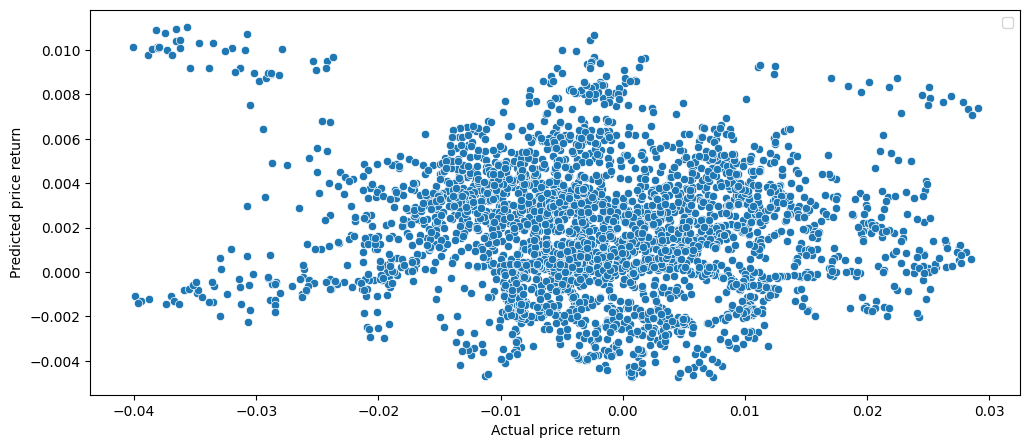

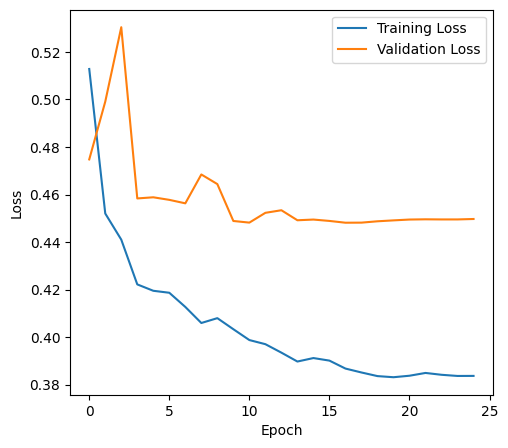

=== Cross-validation (validation folds) ===
mean CV MSE: 0.00017434130131732672
mean CV MAE: 0.009652200154960155
mean CV DA: 0.5321722302854378
mean CV SR: 0.04354374756600691
mean CV R^2: -0.19395785331726073
mean CV Pearson correlation: -0.00217018136754632


/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


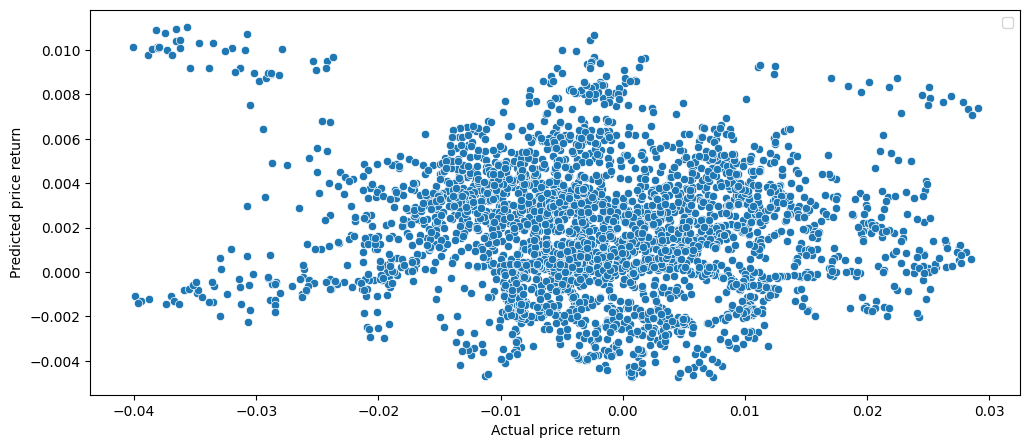

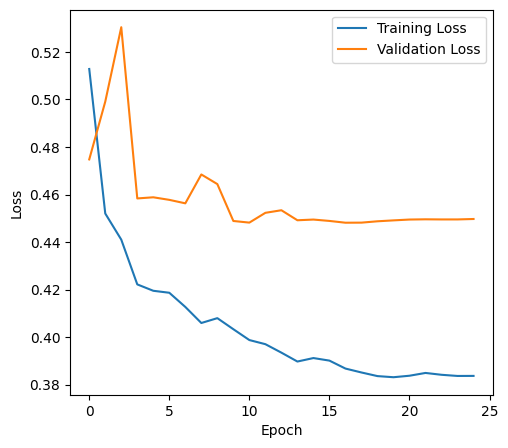

successfully saved training's output to lstm_btc_scores_final_comments_2.json


In [ ]:
lstm_2_scores, lstm_2_history = train_price_prediction_model(X, y, ModelType.LSTM, split, "lstm_btc_scores_final_comments_2.json", dropout=0.1, num_neurons=32, num_layers=1, batch_size=64, seq_length=64, learning_rate=0.001, epochs=100, loss_funtion=LossFunction.HUBER)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.8305 - val_loss: 0.8508 - learning_rate: 0.0020
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6770 - val_loss: 0.8763 - learning_rate: 0.0020
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6157 - val_loss: 0.8544 - learning_rate: 0.0020
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5822 - val_loss: 0.8804 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5392 - val_loss: 0.8895 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5376 - val_loss: 0.8957 - learning_rate: 5.0000e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5205 - val_loss: 0.8949 - learning_rate: 5.0000e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5045 - val_loss: 0.8999 - learning_rate: 2.5000e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5158 - val_loss: 0.9022 - learning_rate: 2.500

/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


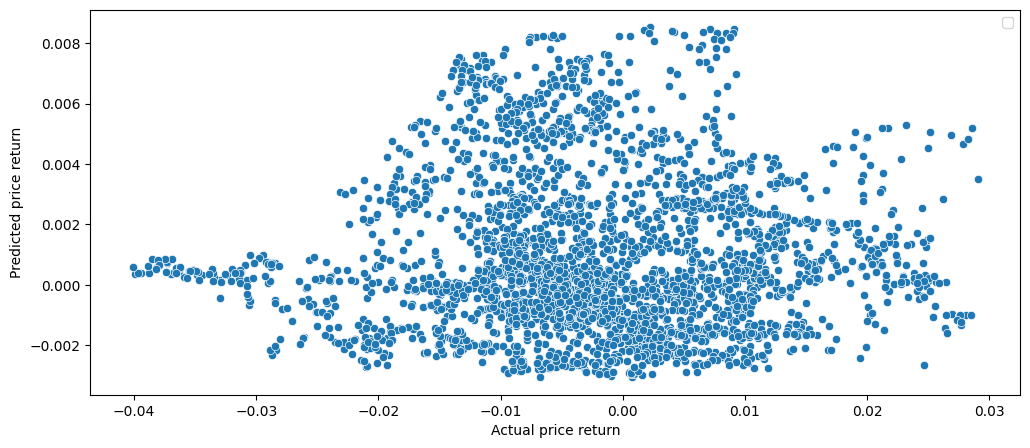

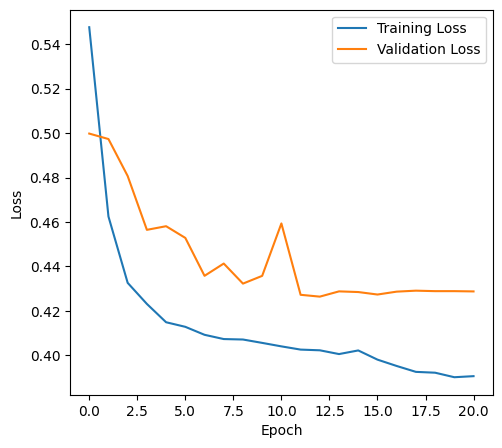

=== Cross-validation (validation folds) ===
mean CV MSE: 0.0001651006459724158
mean CV MAE: 0.00967348925769329
mean CV DA: 0.5347847121432027
mean CV SR: 0.13011485062653078
mean CV R^2: -0.1332826018333435
mean CV Pearson correlation: 0.034885965287685394


/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


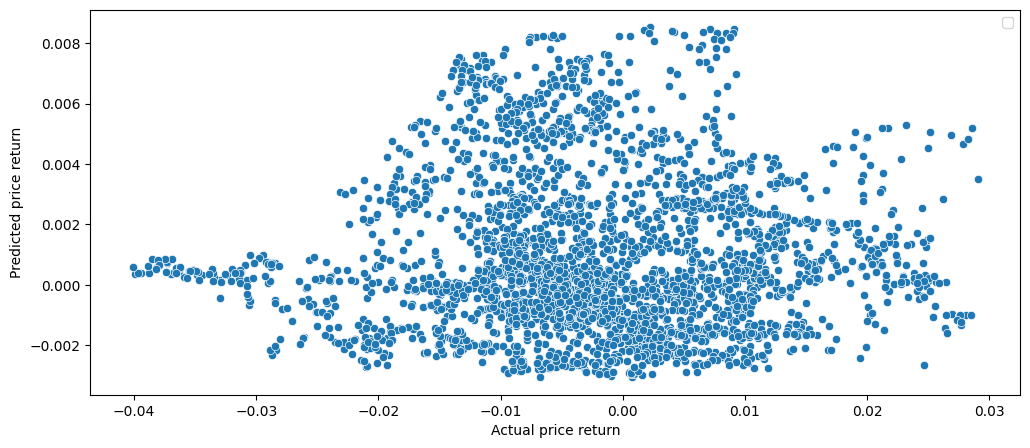

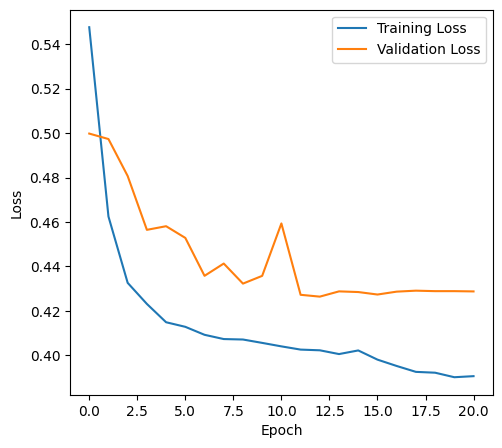

successfully saved training's output to lstm_btc_scores_final_comments_3.json


In [ ]:
lstm_3_scores, lstm_3_history = train_price_prediction_model(X, y, ModelType.LSTM, split, "lstm_btc_scores_final_comments_3.json", dropout=0.7, num_neurons=48, num_layers=1, batch_size=64, seq_length=64, learning_rate=0.002, epochs=100, loss_funtion=LossFunction.HUBER)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.7752 - val_loss: 0.7850 - learning_rate: 0.0020
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6327 - val_loss: 0.7676 - learning_rate: 0.0020
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6254 - val_loss: 0.7865 - learning_rate: 0.0020
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6210 - val_loss: 0.7588 - learning_rate: 0.0020
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6160 - val_loss: 0.7580 - learning_rate: 0.0020
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6001 - val_loss: 0.7852 - learning_rate: 0.0020
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6039 - val_loss: 0.7847 - learning_rate: 0.0020
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6021 - val_loss: 0.7838 - learning_rate: 0.0010
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5992 - val_loss: 0.8004 - learning_rate: 0.0010
Epoch 10/1

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_40
Received: inputs=['Tensor(shape=(500, 64, 30))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_40
Received: inputs=['Tensor(shape=(50, 64, 30))']
  warnings.warn(msg)
/content/drive/MyDrive/magisterka/model_training/price_model_training.py:414: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


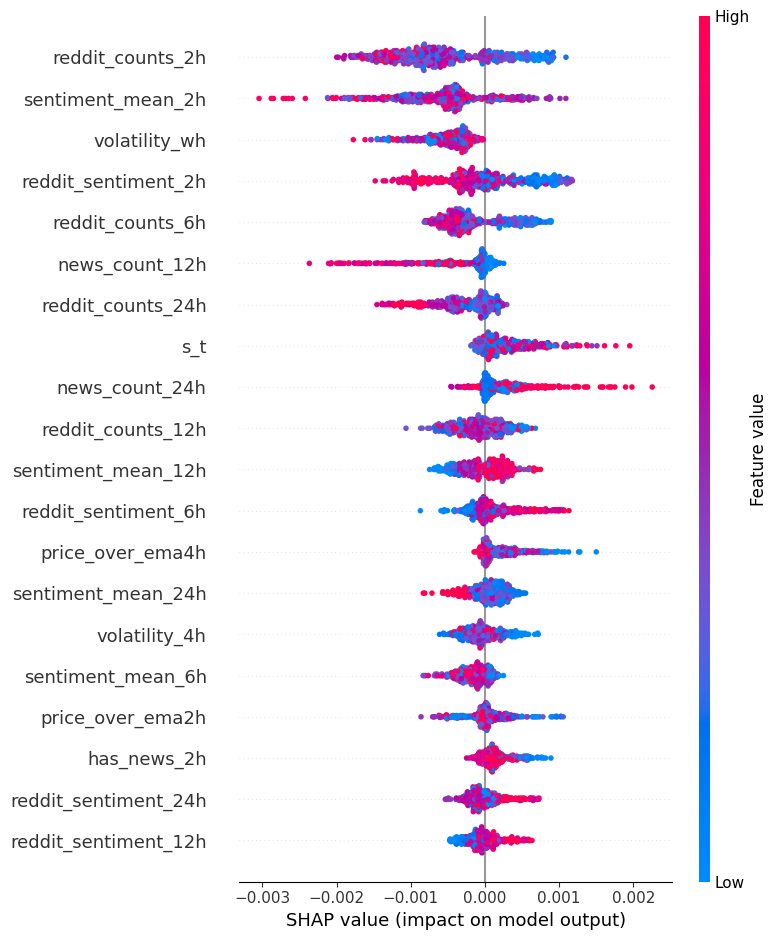

[FINAL TEST] mse: 0.000143926 | mae: 0.00937584 | da: 0.437 | sr: -0.093 | r_squared: -0.103 | corr: 0.115


/content/drive/MyDrive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


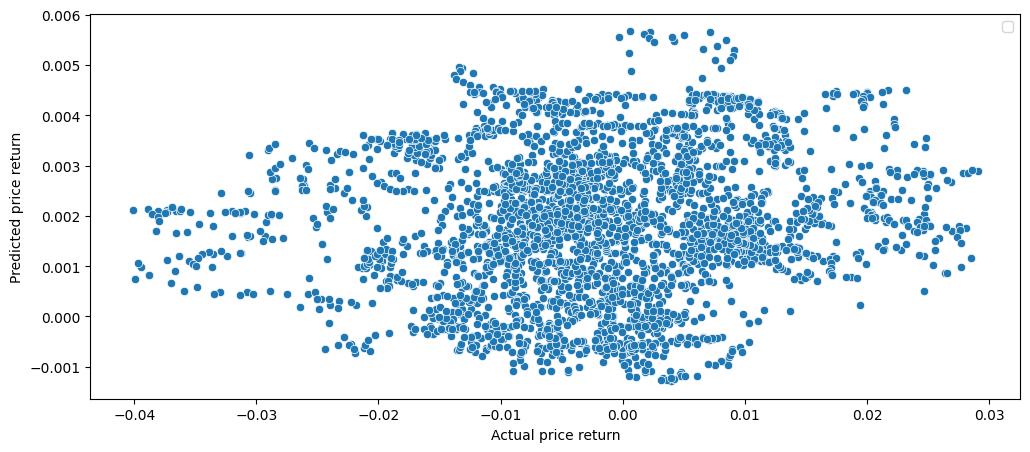

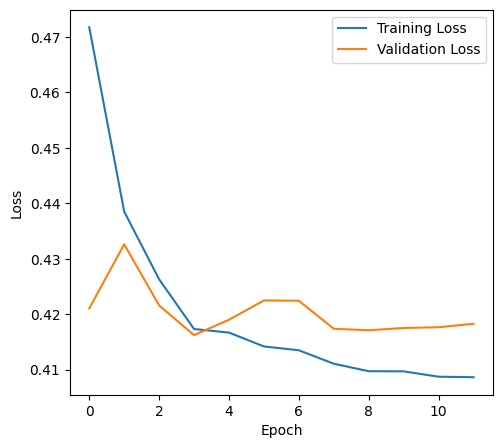

=== Cross-validation (validation folds) ===
mean CV MSE: 0.00016064623196143657
mean CV MAE: 0.009522495791316032
mean CV DA: 0.5405902273826803
mean CV SR: 0.17733879689764964
mean CV R^2: -0.10491311550140381
mean CV Pearson correlation: 0.02983863092958927


/content/drive/MyDrive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


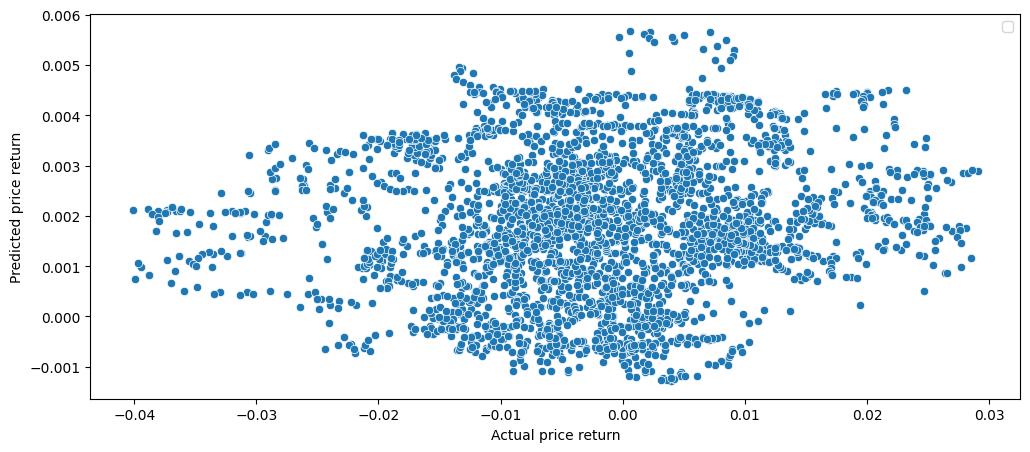

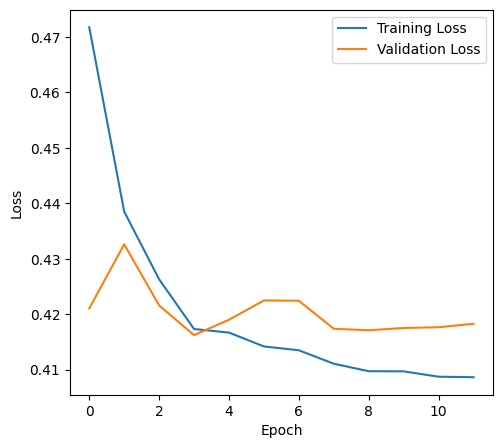

successfully saved training's output to lstm_btc_scores_final_comments_4.json


In [12]:
lstm_4_scores, lstm_4_history = train_price_prediction_model(X, y, ModelType.LSTM, split, "lstm_btc_scores_final_comments_4.json", dropout=0.7, num_neurons=24, num_layers=2, batch_size=64, seq_length=64, learning_rate=0.002, epochs=100, loss_funtion=LossFunction.HUBER, plot_shap_values=True)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.9299 - val_loss: 0.8540 - learning_rate: 0.0020
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5605 - val_loss: 0.8283 - learning_rate: 0.0020
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4982 - val_loss: 0.9611 - learning_rate: 0.0020
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4554 - val_loss: 0.9451 - learning_rate: 0.0020
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3422 - val_loss: 0.9993 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3475 - val_loss: 0.9908 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2739 - val_loss: 1.0152 - learning_rate: 5.0000e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2597 - val_loss: 1.0307 - learning_rate: 5.0000e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2518 - val_loss: 1.0405 - learning_rate: 2.5000e-0

/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


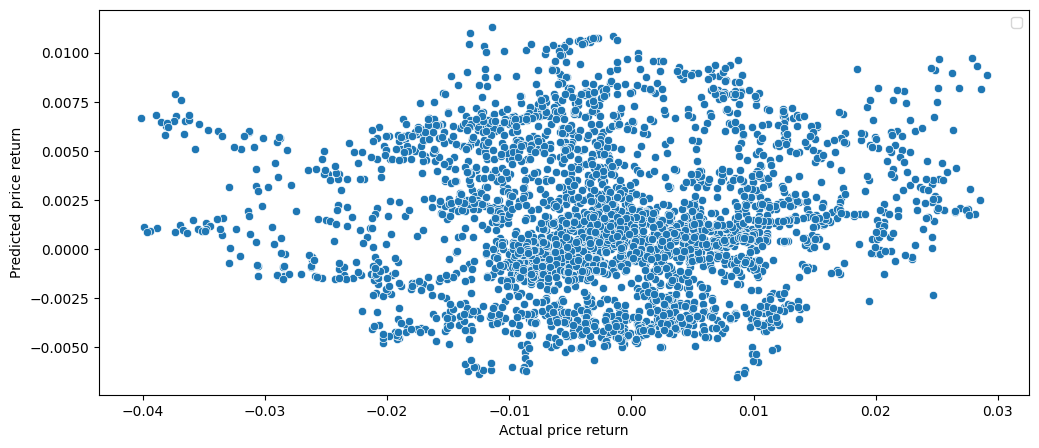

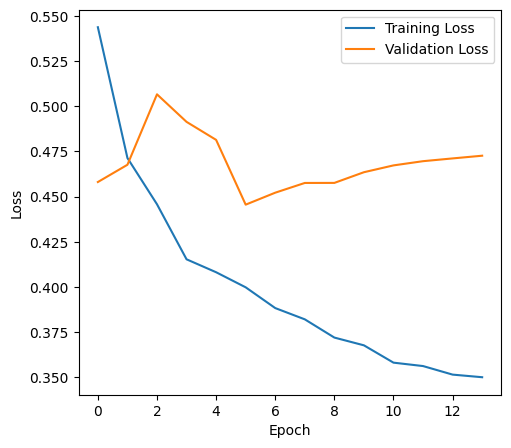

=== Cross-validation (validation folds) ===
mean CV MSE: 0.00017151662905234843
mean CV MAE: 0.0098955063149333
mean CV DA: 0.5139816158684083
mean CV SR: 0.061352006761880976
mean CV R^2: -0.1921097755432129
mean CV Pearson correlation: -0.0008562385919503868


/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


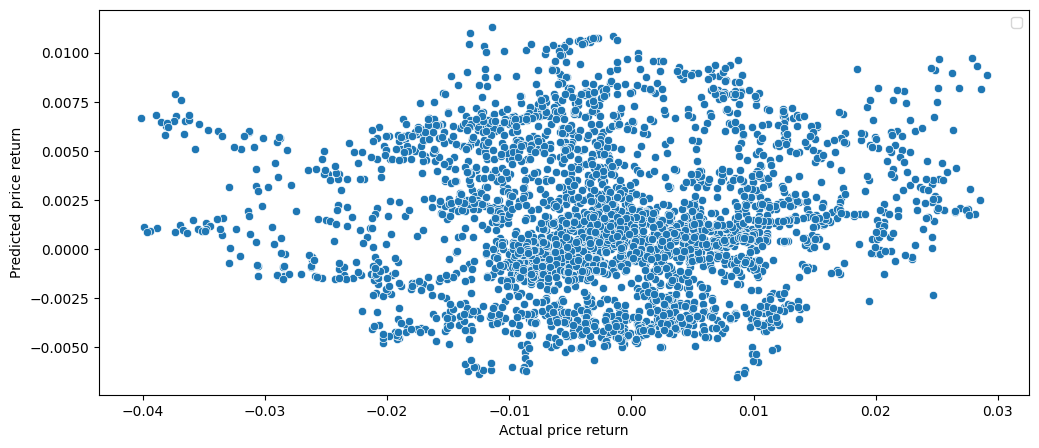

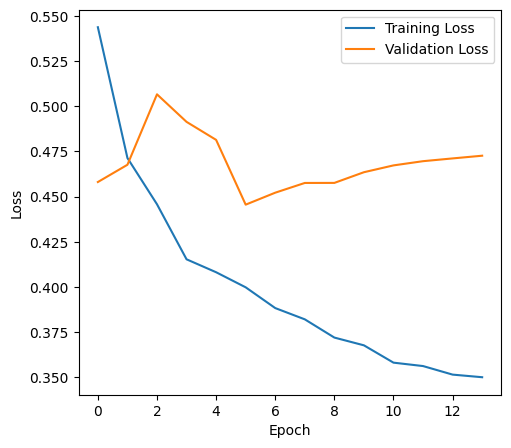

successfully saved training's output to lstm_btc_scores_final_comments_5.json


In [ ]:
lstm_5_scores, lstm_5_history = train_price_prediction_model(X, y, ModelType.LSTM, split, "lstm_btc_scores_final_comments_5.json", dropout=0.2, num_neurons=24, num_layers=1, batch_size=64, seq_length=64, learning_rate=0.002, epochs=100, loss_funtion=LossFunction.HUBER)

# GRU - trenowanie

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.7303 - val_loss: 0.7594 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6379 - val_loss: 0.7653 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6434 - val_loss: 0.7683 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6204 - val_loss: 0.7725 - learning_rate: 5.0000e-04
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6249 - val_loss: 0.7830 - learning_rate: 5.0000e-04
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5961 - val_loss: 0.7968 - learning_rate: 2.5000e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6082 - val_loss: 0.7949 - learning_rate: 2.5000e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6087 - val_loss: 0.7969 - learning_rate: 1.2500e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6016 - val_loss: 0.7965 - learning_rat

/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


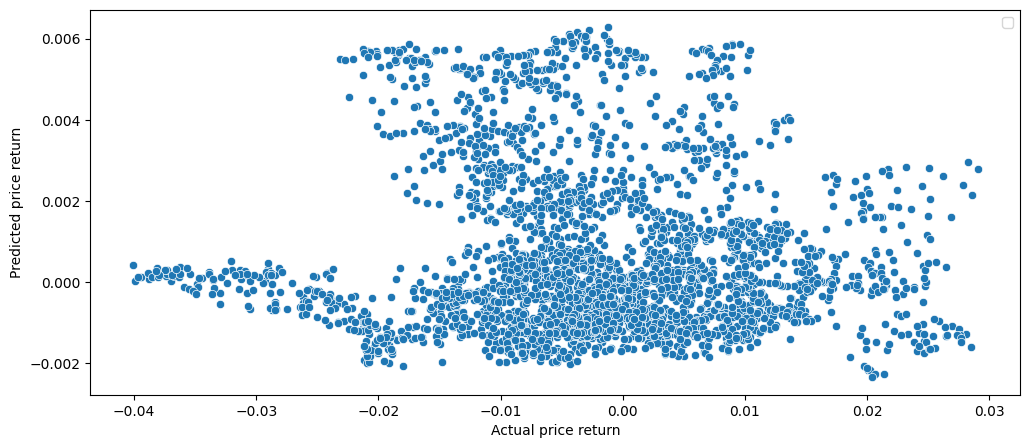

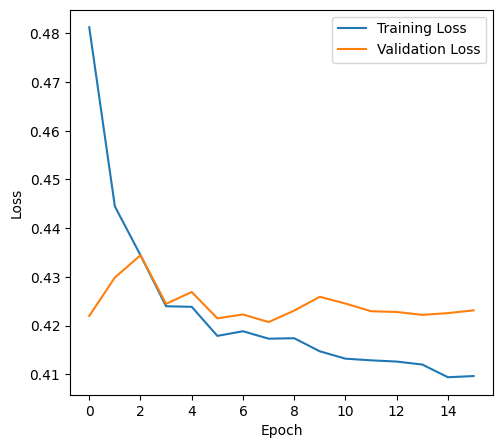

=== Cross-validation (validation folds) ===
mean CV MSE: 0.00016413975390605628
mean CV MAE: 0.009548190049827099
mean CV DA: 0.525399129172714
mean CV SR: 0.09005275326977633
mean CV R^2: -0.1335692286491394
mean CV Pearson correlation: 0.07776542752981186


/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


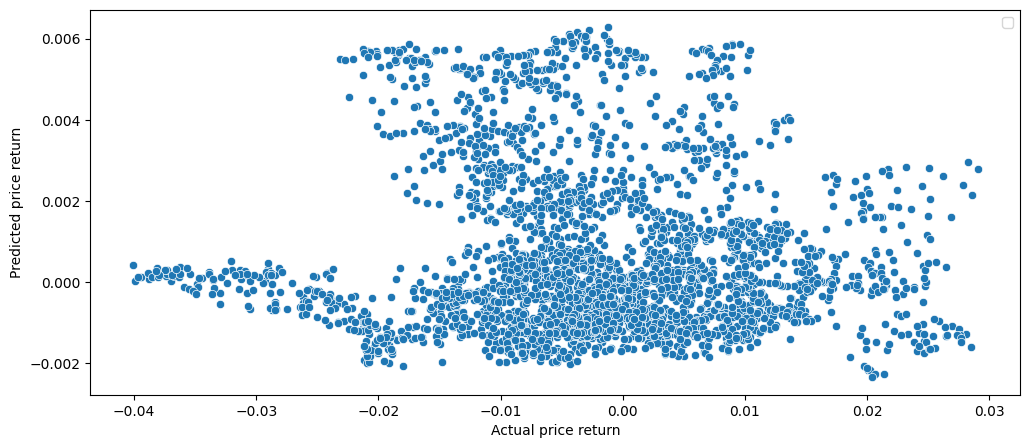

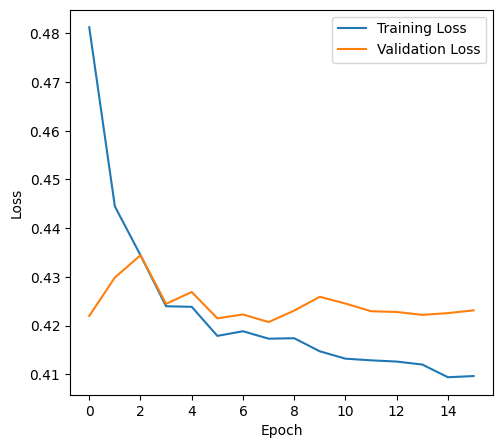

successfully saved training's output to gru_btc_scores_1_final_comments.json


In [ ]:
gru_1_scores, gru_1_history = train_price_prediction_model(X, y, ModelType.GRU, split, "gru_btc_scores_1_final_comments.json", dropout=0.7, num_neurons=32, batch_size=64, seq_length=64, learning_rate=0.001, epochs=100, loss_funtion=LossFunction.HUBER)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.7893 - val_loss: 0.8318 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6152 - val_loss: 0.8392 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5924 - val_loss: 0.8456 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5792 - val_loss: 0.8551 - learning_rate: 5.0000e-04
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5664 - val_loss: 0.8687 - learning_rate: 5.0000e-04
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5463 - val_loss: 0.8715 - learning_rate: 2.5000e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5602 - val_loss: 0.8756 - learning_rate: 2.5000e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5353 - val_loss: 0.8761 - learning_rate: 1.2500e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5366 - val_loss: 0.8780 - learning_rat

/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


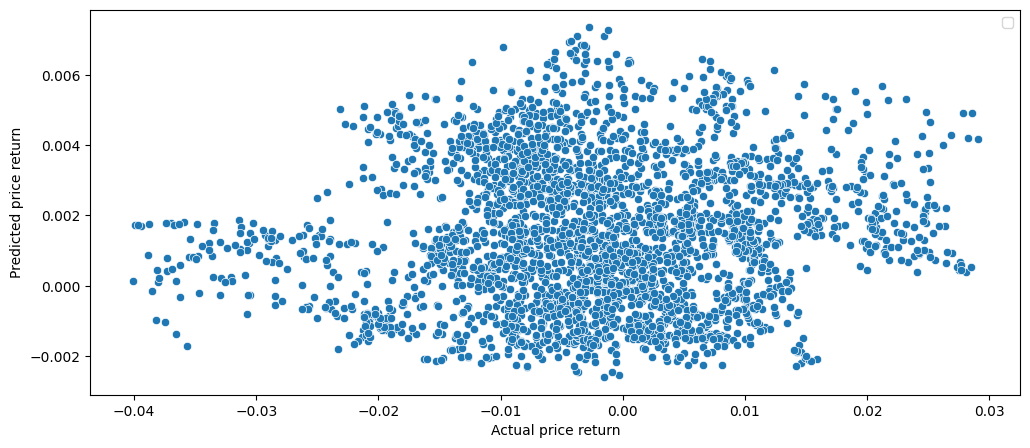

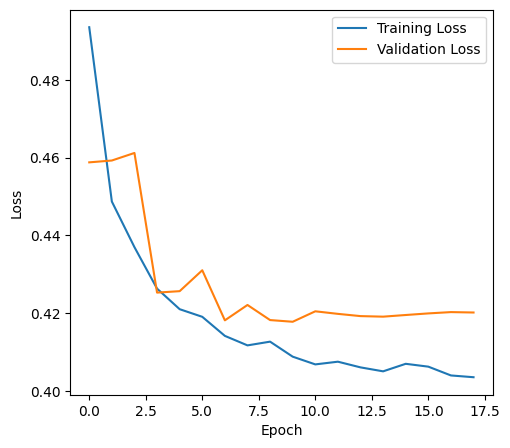

=== Cross-validation (validation folds) ===
mean CV MSE: 0.00017008335271384567
mean CV MAE: 0.00967065617442131
mean CV DA: 0.5262699564586357
mean CV SR: 0.1012012050326861
mean CV R^2: -0.16458547115325928
mean CV Pearson correlation: 7.873773938626982e-06


/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


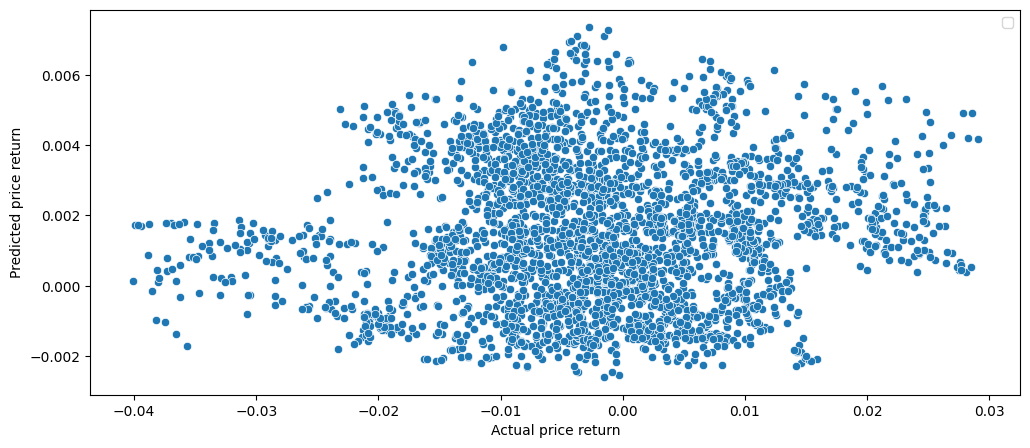

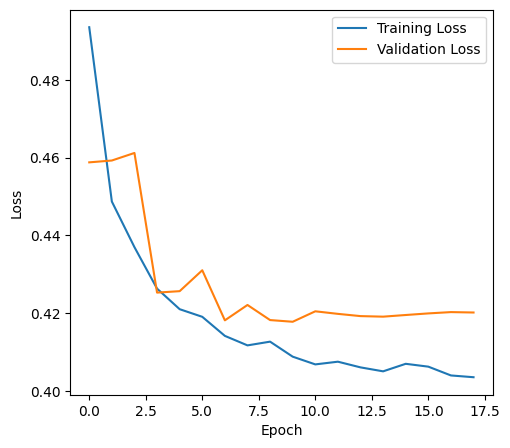

successfully saved training's output to gru_btc_scores_final_comments_2.json


In [ ]:
gru_2_scores, gru_2_history = train_price_prediction_model(X, y, ModelType.GRU, split, "gru_btc_scores_final_comments_2.json", dropout=0.7, num_neurons=32, num_layers=1, batch_size=64, seq_length=64, learning_rate=0.001, epochs=100, loss_funtion=LossFunction.HUBER)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.0639 - val_loss: 1.0975 - learning_rate: 0.0020
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8262 - val_loss: 0.8854 - learning_rate: 0.0020
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6184 - val_loss: 0.8855 - learning_rate: 0.0020
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5326 - val_loss: 1.0356 - learning_rate: 0.0020
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5286 - val_loss: 1.0096 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3931 - val_loss: 1.0308 - learning_rate: 0.0010
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3506 - val_loss: 1.0089 - learning_rate: 5.0000e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3384 - val_loss: 1.0223 - learning_rate: 5.0000e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3274 - val_loss: 1.0234 - learning_rate: 2.5000e-0

/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


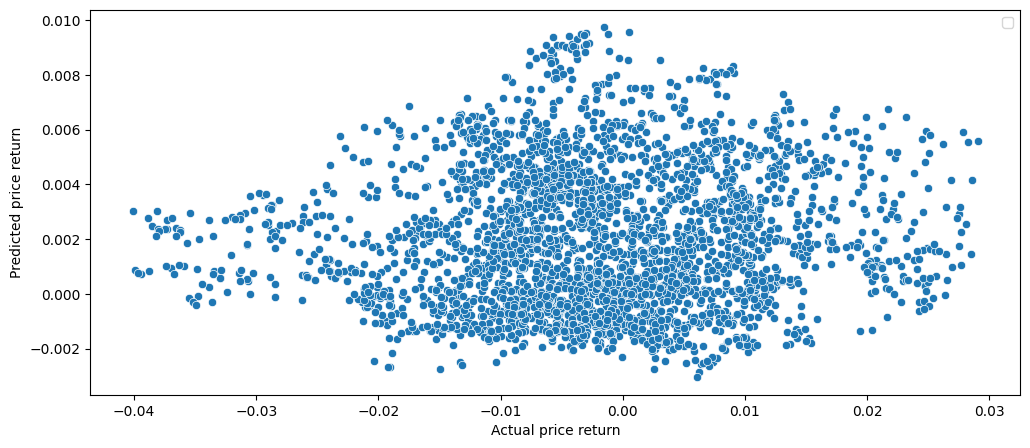

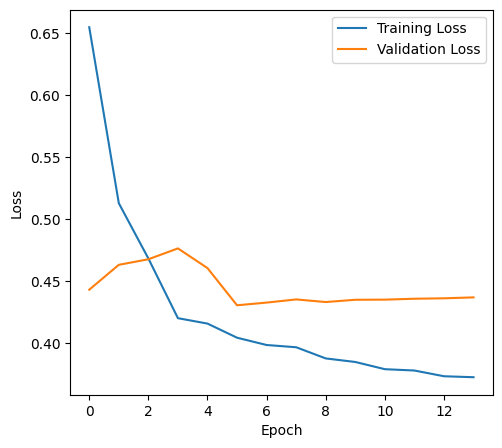

=== Cross-validation (validation folds) ===
mean CV MSE: 0.0001758546131895855
mean CV MAE: 0.010071058757603168
mean CV DA: 0.5051765844218674
mean CV SR: 0.07116075528849897
mean CV R^2: -0.22888388633728027
mean CV Pearson correlation: 0.009315567091107368


/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


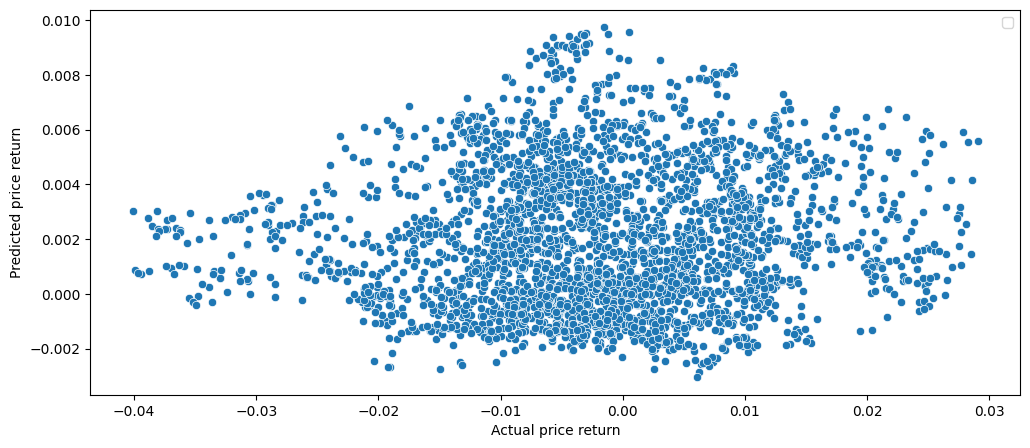

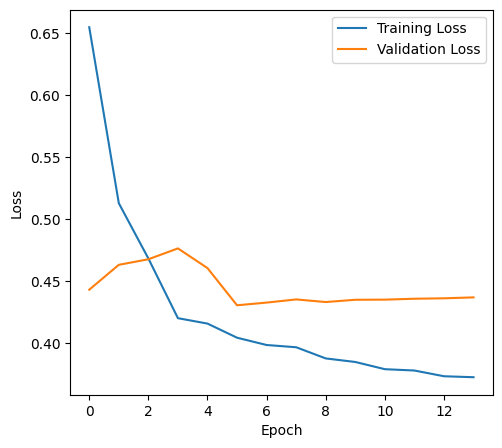

successfully saved training's output to gru_btc_scores_final_comments_3.json


In [ ]:
gru_3_scores, gru_3_history = train_price_prediction_model(X, y, ModelType.GRU, split, "gru_btc_scores_final_comments_3.json", dropout=0.2, num_neurons=48, num_layers=1, batch_size=64, seq_length=64, learning_rate=0.002, epochs=100, loss_funtion=LossFunction.HUBER)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.0825 - val_loss: 0.8810 - learning_rate: 0.0020
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7136 - val_loss: 0.9565 - learning_rate: 0.0020
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7135 - val_loss: 1.0383 - learning_rate: 0.0020
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7945 - val_loss: 0.9249 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5022 - val_loss: 0.9631 - learning_rate: 0.0010
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4930 - val_loss: 0.9459 - learning_rate: 5.0000e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4074 - val_loss: 0.9532 - learning_rate: 5.0000e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3826 - val_loss: 0.9636 - learning_rate: 2.5000e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3682 - val_loss: 0.9694 - learning_rate: 2.500

/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


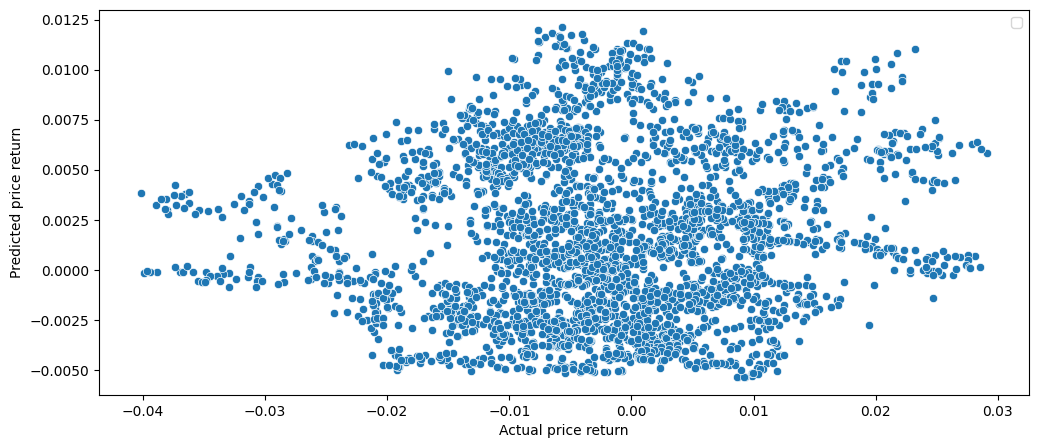

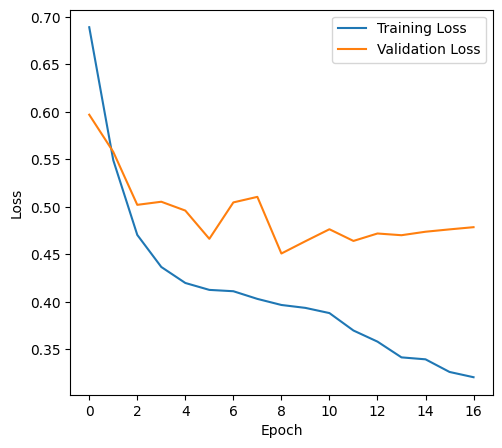

=== Cross-validation (validation folds) ===
mean CV MSE: 0.00017826250405050814
mean CV MAE: 0.009833579882979393
mean CV DA: 0.5393323657474601
mean CV SR: 0.06873713958404037
mean CV R^2: -0.22229394912719727
mean CV Pearson correlation: 0.051801227033138275


/content/drive/My Drive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


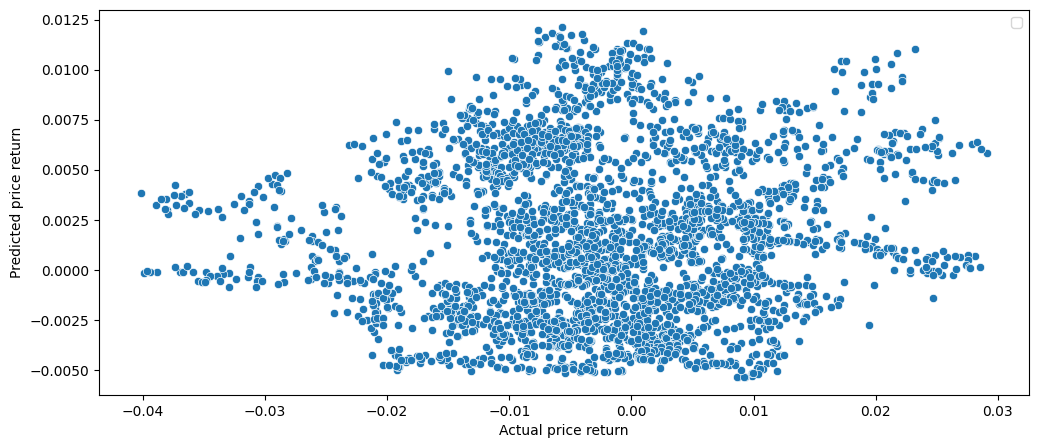

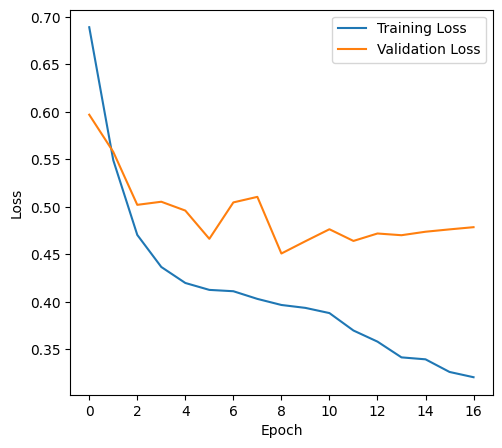

successfully saved training's output to gru_btc_scores_final_comments_4.json


In [ ]:
gru_4_scores, gru_4_history = train_price_prediction_model(X, y, ModelType.GRU, split, "gru_btc_scores_final_comments_4.json", dropout=0.2, num_neurons=64, num_layers=1, batch_size=64, seq_length=64, learning_rate=0.002, epochs=100, loss_funtion=LossFunction.HUBER)

# ARIMA - trenowanie

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss

In [14]:
def adf_test(series):
    result = adfuller(series, autolag="AIC")
    return {
        "ADF statistic": result[0],
        "p-value": result[1],
        "used lags": result[2],
        "nobs": result[3]
    }
def kpss_test(series, regression="c"):
    statistic, p_value, n_lags, _ = kpss(series, regression=regression, nlags="auto")
    return {
        "KPSS statistic": statistic,
        "p-value": p_value,
        "used lags": n_lags
    }

In [15]:
adf_test(y)

{'ADF statistic': np.float64(-8.233172203983386),
 'p-value': np.float64(5.986627036235333e-13),
 'used lags': 36,
 'nobs': 15946}

In [16]:
kpss_test(y)

{'KPSS statistic': np.float64(0.601070837784207),
 'p-value': np.float64(0.02253901474689027),
 'used lags': 74}

In [24]:
adf_test(y.diff().dropna())

{'ADF statistic': np.float64(-22.366007760506704),
 'p-value': 0.0,
 'used lags': 35,
 'nobs': 15946}

In [17]:
kpss_test(y.diff().dropna())

/tmp/ipython-input-1810698995.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, _ = kpss(series, regression=regression, nlags="auto")


{'KPSS statistic': np.float64(0.004046126975845886),
 'p-value': np.float64(0.1),
 'used lags': 1}

In [18]:
d = 1

In [19]:
def select_pq(y, d, p_max=5, q_max=5):
    best = {"aic": np.inf, "order": None, "result": None}
    for p in range(p_max + 1):
        for q in range(q_max + 1):
            try:
                res = SARIMAX(
                    y, order=(p, d, q),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                if res.aic < best["aic"]:
                    best = {"aic": res.aic, "order": (p, d, q), "result": res}
            except Exception:
                pass
    return best["order"], best["aic"]

order, aic = select_pq(y, d=1, p_max=5, q_max=5)
order, aic

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will

((1, 1, 1), np.float64(-166004.0744370534))

In [20]:
y_acf = y[::12*12]

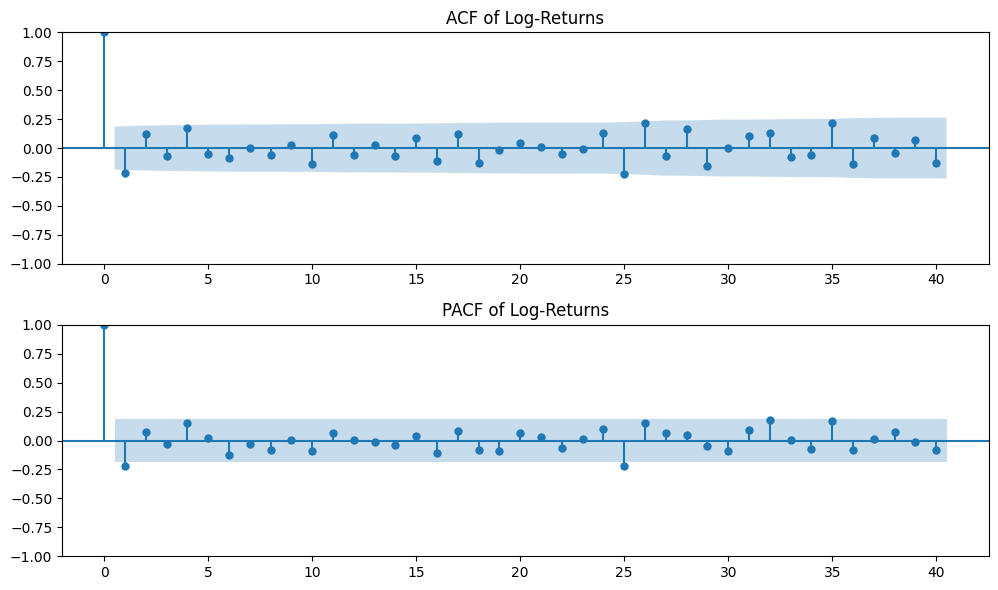

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(y_acf, lags=40, ax=ax[0])
ax[0].set_title("ACF of Log-Returns")

plot_pacf(y_acf, lags=40, ax=ax[1])
ax[1].set_title("PACF of Log-Returns")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV fold 1] mse: 0.000278007 | mae: 0.0123805 | da: 0.469 | sr: 0.111


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


[CV fold 2] mse: 8.85083e-05 | mae: 0.00678734 | da: 0.569 | sr: 0.062


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV fold 3] mse: 0.000370112 | mae: 0.0149926 | da: 0.331 | sr: -0.486


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


[CV fold 4] mse: 0.000130731 | mae: 0.00898583 | da: 0.541 | sr: 0.050


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[CV fold 5] mse: 0.00089153 | mae: 0.0261119 | da: 0.433 | sr: -0.261


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[FINAL TEST] mse: 0.000128195 | mae: 0.00885316 | da: 0.581 | sr: 0.235 | r_squared: 0.004 | corr: 0.203


/content/drive/MyDrive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


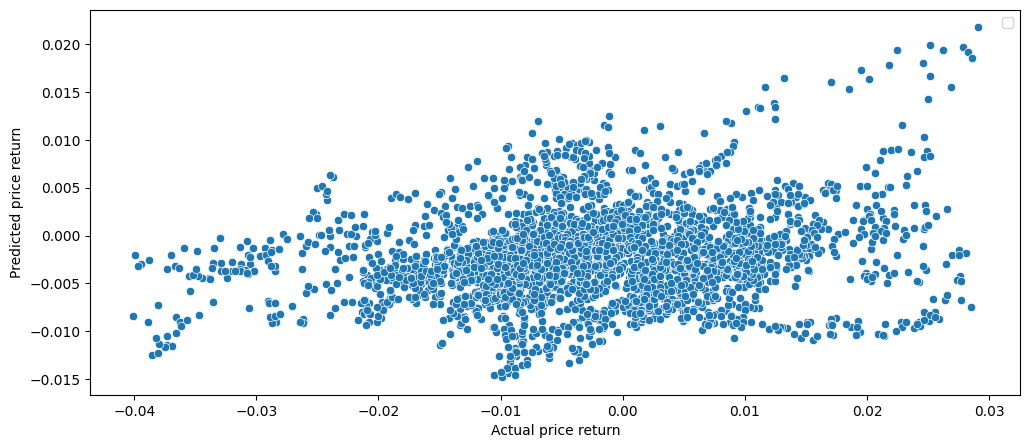

=== Cross-validation (validation folds) ===
mean CV MSE: 0.0003517775001956625
mean CV MAE: 0.013851630877516735
mean CV DA: 0.46863849765258214
mean CV SR: -0.10485749002028241
mean CV R^2: -1.1869649982170787
mean CV Pearson correlation: 0.034979918150988734


/content/drive/MyDrive/magisterka/model_training/model_training_plots.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


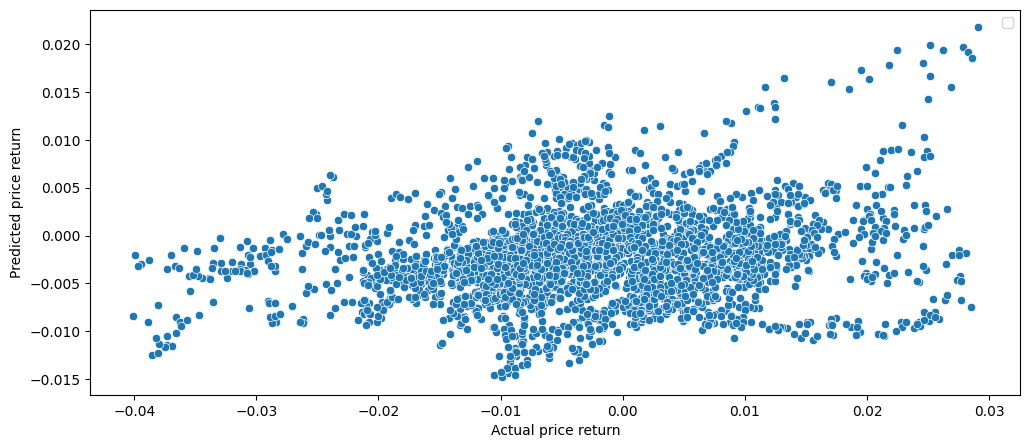

successfully saved training's output to arima_btc_scores_1_final_comments.json


In [23]:
arima_scores, arima_history = train_price_prediction_model(X, y, ModelType.ARIMA, split, "arima_btc_scores_1_final_comments.json", epochs=100, order=(1,1,1))